# Segmentation de clients d'un site e-commerce

Sommaire

## 0. Mise en place
* Imports des librairies
* Import du jeux de données

### 0.1 Import des librairies

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_extraction import FeatureHasher

In [2]:
def show_values_on_bars(axs, vertical=True, space=0.4):
    """
    Affiche les valeurs d'un barplot.
    """
    def _show_on_single_plot(ax):
        if vertical == True:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + space
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif vertical == False:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + space
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def display_filling_of_col(df, line=0, color='#3556C8', figsize=(8, 5), show_values=False):
    df_tmp = pd.DataFrame()
    for col in df.columns:
        df_tmp[col] = pd.Series(df[col].count())
    x = list(df_tmp.T.sort_values(by=0, ascending=False)[0] / df.shape[0] * 100)
    y = list(df_tmp.T.sort_values(by=0, ascending=False).index)
    fig, ax = plt.subplots(figsize=figsize)
    if line == 0:
        sns.barplot(x=x, 
                    y=y,
                   orient='h', color=color)
    else:
        sns.barplot(x=x[:line], 
                    y=y[:line],
                   orient='h', color=color)
    if show_values == True:
        show_values_on_bars(ax, vertical=False)

### 0.2 Import des données

In [3]:
path = r'Data\\'

In [4]:
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(path + 'olist_orders_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv(path + 'product_category_name_translation.csv')

![img](https://i.imgur.com/HRhd2Y0.png)

In [5]:
# Collections for each dataset
datasets = [customers, geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers, product_category_name_translation]
names = ['customer', 'geolocation', 'orders', 'order_items', 'order_payments',
         'order_reviews', 'products', 'sellers', 'product_category_name_translation']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,customer,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,order_items,112650,7,0,0,
4,order_payments,103886,5,0,0,
5,order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,3095,4,0,0,
8,product_category_name_translation,71,2,0,0,


### 0.3 Assemblage du jeux de données
Jointure des différents dataset pour en avoir un unique

In [6]:
# Product information

full_products = order_items.join(products.set_index("product_id"),
                                 on="product_id")\
                           .join(sellers.set_index("seller_id"),
                                 on="seller_id")

In [7]:
# Order information

full_orders = orders.join(order_reviews.set_index("order_id"),
                          on='order_id')\
                    .join(order_payments.set_index("order_id"),
                          on='order_id')\
                    .join(full_products.set_index("order_id"),
                          on='order_id')

In [8]:
# Full data set with orders, products and clients

full_dataset = full_orders.join(customers.set_index("customer_id"),
                                on="customer_id")

In [9]:
full_dataset.shape

(119151, 39)

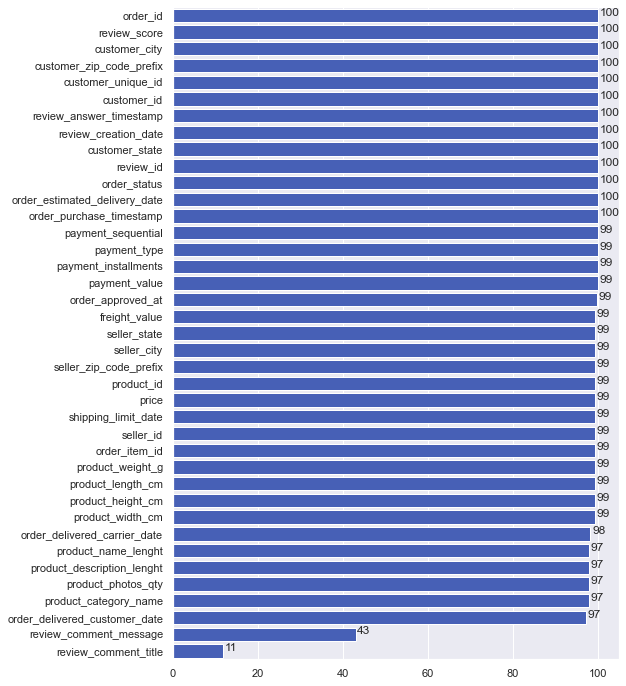

In [10]:
display_filling_of_col(full_dataset, show_values=True, figsize=(8, 12))

## 1. NETTOYAGE

### 1.1 Conversion des dates

In [11]:
# Converting to datetime

cols_to_timestamp = ["order_approved_at",
                     "order_delivered_carrier_date",
                     "order_delivered_customer_date",
                     "order_estimated_delivery_date",
                     "order_purchase_timestamp",
                     "review_answer_timestamp",
                     "review_creation_date",
                     "shipping_limit_date"]

for col in cols_to_timestamp:
    full_dataset[col] = pd.to_datetime(full_dataset[col],
                                       format='%Y-%m-%d %H:%M:%S')

In [12]:
# Converting to string

full_dataset["seller_zip_code_prefix"] = full_dataset\
                                        .loc[:, "seller_zip_code_prefix"].astype("str")
full_dataset["customer_zip_code_prefix"] = full_dataset["customer_zip_code_prefix"]\
                                           .astype(str)

### 1.2 Suppression des outliers

In [13]:
# Deleting products that have a weight <= 0

print(f"Avant : {full_dataset.shape[0]}\n\
Nb supprimé : {full_dataset.shape[0] - full_dataset[full_dataset['product_weight_g'] > 0].shape[0]} \
| {(full_dataset.shape[0] - full_dataset[full_dataset['product_weight_g'] > 0].shape[0]) / full_dataset.shape[0] * 100:.2f} %")
full_dataset = full_dataset[full_dataset["product_weight_g"] > 0]
print(f"Apres : {full_dataset.shape[0]}")

Avant : 119151
Nb supprimé : 861 | 0.72 %
Apres : 118290


In [14]:
# Deleting canceled orders that are marked as delivered

full_dataset = full_dataset[~((full_dataset['order_status'] == 'canceled') & (full_dataset["order_delivered_customer_date"].notnull()))]

In [15]:
# Deleting orders with incoherent event flow :
# 1) order_approved_at < order_delivered_carrier_date < order_delivered_customer_date 
#    < review_creation_date < review_answer_timestamp
# 2) order_approved_at < shipping_limit_date

In [16]:
# Deleting orders where order_approved_at < order_delivered_carrier_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["order_delivered_carrier_date"])]

In [17]:
# Deleting orders where order_approved_at < order_delivered_customer_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["order_delivered_customer_date"])]

In [18]:
# Deleting orders where order_approved_at < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["review_creation_date"])]

In [19]:
# Deleting orders where order_approved_at < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                             > \
                             full_dataset["review_answer_timestamp"])]

In [20]:
# Deleting orders where order_approved_at < shipping_limit_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["shipping_limit_date"])]

_order_delivered_carrierdate

In [21]:
# Deleting orders where order_delivered_carrier_date < order_delivered_customer_date

full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
                              > \
                              full_dataset["order_delivered_customer_date"])]

In [22]:
# Deleting orders where order_delivered_carrier_date < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
                              > \
                              full_dataset["review_creation_date"])]

_order_delivered_customerdate

In [23]:
# Deleting orders where order_delivered_customer_date < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"]\
                              >\
                              full_dataset["review_creation_date"])]

In [24]:
# Deleting orders where order_delivered_customer_date < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"] \
                              > \
                              full_dataset["review_answer_timestamp"])]

_review_creationdate

In [25]:
# Deleting orders where review_creation_date < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["review_creation_date"] \
                              > \
                              full_dataset["review_answer_timestamp"])]

In [26]:
print(f"Lignes supprimés : {118290 - full_dataset.shape[0]} | \
{(118290 - full_dataset.shape[0]) / 118290 * 100:.2f} %\n\
Nb de lignes : {full_dataset.shape[0]}")

Lignes supprimés : 11315 | 9.57 %
Nb de lignes : 106975


### 1.3 Suppression des lignes totalement vide

In [27]:
print(f"Lignes entièrement vides : {full_dataset.shape[0] - full_dataset.dropna(how='all', axis=1).shape[0]}")

Lignes entièrement vides : 0


## 2. Selection des données

In [28]:
# Data since january 2017

full_dataset = full_dataset[full_dataset["order_purchase_timestamp"].dt.year > 2016]

## 3. Feature Engineering

Segmentation RMFP (Récence – Fréquence – Montant – Produit)  
[Average online shopping value in Brazil from 2017 to 2020](https://www.statista.com/statistics/255337/average-b2c-e-commerce-sales-per-digital-buyer-in-brazil/)

### 3.1 Feature creation

In [29]:
# Average basket for e-commerce in Brazil

AVERAGE_BASKET = {2017:417, 2018:420}

In [30]:
def get_recency_score(purchase_date, actual_year):
    return max(1,
               10-round((pd.Timestamp(year=actual_year,
                                      month=12,
                                      day=31) - purchase_date)/np.timedelta64(1, 'M')))

#------------------------------------------
def get_monetary_score(average_customer_basket, AVERAGE_BASKET):
    return round((average_customer_basket/AVERAGE_BASKET)*100)

In [31]:
def feature_transformation(full_dataset, year, AVERAGE_BASKET):
    data_year = full_dataset[full_dataset["order_purchase_timestamp"].dt.year == year]
    duplicates = data_year[data_year["customer_id"].duplicated()]["customer_id"]
    clients_multiple_lines_year = data_year[data_year["customer_id"].isin(duplicates)]
    clients_unique_line_year = data_year[~data_year["customer_id"].isin(duplicates)]
    
    new_cols = ["customer_id", "customer_city", "customer_state",
                "nb_orders", "nb_items_order", "canceled_orders",
                "first_order_date", "last_order_date",
                "payment_installments", "payment_sequential", "payment_type",
                "average_basket", "freight_value",
                "product_category_name",
                "product_height_cm", "product_length_cm",
                "product_width_cm", "product_weight_g",
                "product_volume_cm3", "review_score",
                "R_score", "F_score", "M_score"]

    customer_data_year = pd.DataFrame(columns=new_cols)
    
    for customer_id, data_customer in clients_multiple_lines_year.groupby("customer_id"):

        means = data_customer.drop(columns=["order_id", "customer_id", "order_purchase_timestamp",
                                            "product_id", "customer_unique_id"]).mean()
        modes = data_customer.drop(columns=["order_id", "customer_id", "order_purchase_timestamp",
                                            "product_id", "customer_unique_id"]).mode().T

        #Preparing row

        customer_city = modes.loc["customer_city", 0]
        customer_state = modes.loc["customer_state", 0]
        nb_orders = data_customer["order_id"].nunique()
        nb_items_order = data_customer[["order_id", "product_id"]].groupby("order_id")\
                                                                  .count()["product_id"].mean()
        canceled_orders = data_customer[data_customer["order_status"] == "canceled"]\
                          ["order_id"].nunique()
        first_order_date = min(data_customer["order_purchase_timestamp"])
        last_order_date = max(data_customer["order_purchase_timestamp"])
        payment_installments = means.loc["payment_installments"]
        payment_sequential = means.loc["payment_sequential"]
        payment_type = modes.loc["payment_type", 0]
        average_basket = data_customer[["order_id", "payment_value"]]\
                         .groupby("order_id").agg("sum")["payment_value"].mean()
        freight_value = means.loc["freight_value"]
        product_category_name = modes.loc["product_category_name", 0]
        product_height_cm = means.loc["product_height_cm"]
        product_length_cm = means.loc["product_length_cm"]
        product_width_cm = means.loc["product_width_cm"]
        product_weight_g = means.loc["product_weight_g"]
        product_volume_cm3 = product_width_cm * product_length_cm * product_height_cm
        review_score = means.loc["review_score"]
        r_score = get_recency_score(max(data_customer["order_purchase_timestamp"]), year)
        f_score = nb_orders if nb_orders <= 10 else 10
        m_score = get_monetary_score(average_basket, AVERAGE_BASKET)

        row = [customer_id, customer_city, customer_state,
               nb_orders, nb_items_order, canceled_orders,
               first_order_date, last_order_date,
               payment_installments, payment_sequential,
               payment_type, average_basket, freight_value, product_category_name,
               product_height_cm, product_length_cm, product_width_cm,
               product_weight_g, product_volume_cm3,
               review_score, r_score, f_score, m_score]

        customer_data_year.loc[len(customer_data_year)] = row

    # Customers with one line

    already_single_customer = pd.DataFrame(columns=new_cols)

    already_single_customer["customer_id"] = clients_unique_line_year["customer_id"]
    already_single_customer["customer_city"] = clients_unique_line_year["customer_city"]
    already_single_customer["customer_state"] = clients_unique_line_year["customer_state"]
    already_single_customer["nb_orders"] = 1
    already_single_customer["nb_items_order"] = 1
    already_single_customer["canceled_orders"] = clients_unique_line_year["order_status"]\
                                         .apply(lambda x: 1 if x != "canceled" else 0)
    already_single_customer["first_order_date"] = clients_unique_line_year\
                                                  ["order_purchase_timestamp"]
    already_single_customer["last_order_date"] = clients_unique_line_year\
                                                 ["order_purchase_timestamp"]
    already_single_customer["payment_installments"] = 1
    already_single_customer["payment_sequential"] = 1
    already_single_customer["payment_type"] = clients_unique_line_year["payment_type"]
    already_single_customer["average_basket"] = clients_unique_line_year["payment_value"]
    already_single_customer["freight_value"] = clients_unique_line_year["freight_value"]
    already_single_customer["product_category_name"] = clients_unique_line_year\
                                                       ["product_category_name"]
    already_single_customer["product_height_cm"] = clients_unique_line_year["product_height_cm"]
    already_single_customer["product_length_cm"] = clients_unique_line_year["product_length_cm"]
    already_single_customer["product_width_cm"] = clients_unique_line_year["product_width_cm"]
    already_single_customer["product_weight_g"] = clients_unique_line_year["product_weight_g"]
    already_single_customer["product_volume_cm3"] = clients_unique_line_year["product_height_cm"]\
                                                    * clients_unique_line_year["product_length_cm"]\
                                                    * clients_unique_line_year["product_width_cm"]
    already_single_customer["review_score"] = clients_unique_line_year["review_score"]
    already_single_customer["R_score"] = clients_unique_line_year["order_purchase_timestamp"]\
                                         .apply(lambda x: get_recency_score(x, year))
    already_single_customer["F_score"] = clients_unique_line_year["order_status"]\
                                         .apply(lambda x: 1 if x != "canceled" else 0)
    already_single_customer["M_score"] = clients_unique_line_year["payment_value"]\
                                         .apply(lambda x: get_monetary_score(x, AVERAGE_BASKET))

    # Concaténation des deux dataframes
    final_df = pd.concat([customer_data_year, already_single_customer])
    final_df["nb_orders"] = final_df["nb_orders"].astype("int")
    final_df["canceled_orders"] = final_df["canceled_orders"].astype("int")
    final_df["R_score"] = final_df["R_score"].astype("int")
    final_df["F_score"] = final_df["F_score"].astype("int")
    final_df["M_score"] = final_df["M_score"].astype("int")

    final_df = final_df.drop(columns=["product_height_cm",
                                      "product_length_cm",
                                      "product_width_cm"])

    final_df["first_order_date"] = pd.to_datetime(final_df["first_order_date"],
                                                  format='%Y-%m-%d %H:%M:%S')
    final_df["first_order_year"] = final_df["first_order_date"].apply(lambda x: x.year)
    final_df["first_order_month"] = final_df["first_order_date"].apply(lambda x: x.month)
    final_df["first_order_day"] = final_df["first_order_date"].apply(lambda x: x.day)
    final_df["first_order_hour"] = final_df["first_order_date"].apply(lambda x: x.hour)
    final_df["first_order_min"] = final_df["first_order_date"].apply(lambda x: x.minute)

    final_df["last_order_date"] = pd.to_datetime(final_df["last_order_date"],
                                                 format='%Y-%m-%d %H:%M:%S')
    final_df["last_order_year"] = final_df["last_order_date"].apply(lambda x: x.year)
    final_df["last_order_month"] = final_df["last_order_date"].apply(lambda x: x.month)
    final_df["last_order_day"] = final_df["last_order_date"].apply(lambda x: x.day)
    final_df["last_order_hour"] = final_df["last_order_date"].apply(lambda x: x.hour)
    final_df["last_order_min"] = final_df["last_order_date"].apply(lambda x: x.minute)

    return final_df

In [32]:
customer_data_2017 = feature_transformation(full_dataset,
                                                      2017,
                                                      AVERAGE_BASKET[2017])

<ipython-input-31-4b3e3fd226a1>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  means = data_customer.drop(columns=["order_id", "customer_id", "order_purchase_timestamp",


In [33]:
customer_data_2018 = feature_transformation(full_dataset,
                                                      2018,
                                                      AVERAGE_BASKET[2018])

<ipython-input-31-4b3e3fd226a1>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  means = data_customer.drop(columns=["order_id", "customer_id", "order_purchase_timestamp",


Concaténation

In [34]:
customer_data = pd.concat([customer_data_2017.assign(year='2017'),
                           customer_data_2018.assign(year='2018')])

In [35]:
customer_data = customer_data.reset_index(drop=True)

### 3.2 Encodage

One hot encoding pour les variables avec peu de catégories

In [36]:
cols_to_dummies = ["payment_type"]

customer_data = pd.concat([customer_data[["payment_type"]],
                           pd.get_dummies(customer_data, 
                                          columns=cols_to_dummies)],
                          axis=1)

Feature hasher pour les variables avec plus de catégories

In [37]:
cols_prefix = {"customer_city":"CLI_CITY",
               "customer_state":"CLI_STATE",
               "product_category_name":"PRODUCT_CAT"}

In [38]:
h = FeatureHasher(n_features=6, input_type='string')

In [39]:
for col, pref_col in cols_prefix.items():
    hashed_features = h.fit_transform(customer_data[col].astype("str"))
    hashed_features = hashed_features.toarray()
    hashed_df = pd.DataFrame(hashed_features)\
                .rename(columns={0:pref_col+"_0", 
                                 1:pref_col+"_1", 
                                 2:pref_col+"_2", 
                                 3:pref_col+"_3", 
                                 4:pref_col+"_4", 
                                 5:pref_col+"_5"})

    customer_data = pd.concat([customer_data, hashed_df], axis=1)

In [40]:
customer_data

,payment_type,customer_id,customer_city,customer_state,nb_orders,nb_items_order,canceled_orders,first_order_date,last_order_date,payment_installments,...,CLI_STATE_2,CLI_STATE_3,CLI_STATE_4,CLI_STATE_5,PRODUCT_CAT_0,PRODUCT_CAT_1,PRODUCT_CAT_2,PRODUCT_CAT_3,PRODUCT_CAT_4,PRODUCT_CAT_5
0,credit_card,000bf8121c3412d3057d32371c5d3395,jacarei,SP,1,2.0,0,2017-10-11 07:44:31,2017-10-11 07:44:31,1.0,...,0.0,0.0,0.0,-1.0,0.0,7.0,2.0,-1.0,1.0,-3.0
1,voucher,000e943451fc2788ca6ac98a682f2f49,colorado,RS,1,4.0,0,2017-04-20 19:37:14,2017-04-20 19:37:14,1.0,...,0.0,1.0,0.0,0.0,-1.0,2.0,4.0,1.0,2.0,-3.0
2,credit_card,002f90a6eb386bc43bc9ba200db31a89,sao paulo,SP,1,2.0,0,2017-06-15 23:59:20,2017-06-15 23:59:20,3.0,...,0.0,0.0,0.0,-1.0,-1.0,4.0,1.0,-2.0,1.0,-1.0
3,boleto,00331de1659c7f4fb660c8810e6de3f5,sapiranga,RS,1,3.0,0,2017-12-18 14:54:52,2017-12-18 14:54:52,1.0,...,0.0,1.0,0.0,0.0,0.0,6.0,3.0,-7.0,2.0,-1.0
4,credit_card,003a75d228dc67cb2918e40c2aacc4bf,ponta grossa,PR,1,2.0,0,2017-10-19 12:07:22,2017-10-19 12:07:22,1.0,...,0.0,1.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88726,credit_card,cf97e9cf454480b303de6736ddd15fd6,poa,SP,1,1.0,1,2018-05-12 13:42:24,2018-05-12 13:42:24,1.0,...,0.0,0.0,0.0,-1.0,-2.0,8.0,0.0,-4.0,0.0,0.0
88727,credit_card,6e153567dc52ea59c0498ef5383e9c7a,jundiai,SP,1,1.0,1,2018-06-22 20:53:29,2018-06-22 20:53:29,1.0,...,0.0,0.0,0.0,-1.0,-1.0,2.0,4.0,1.0,2.0,-3.0
88728,credit_card,7b270ebc87c25c8404348c10ff80a80e,belo horizonte,MG,1,1.0,1,2018-03-04 22:48:38,2018-03-04 22:48:38,1.0,...,0.0,1.0,1.0,0.0,-1.0,6.0,2.0,-2.0,0.0,0.0
88729,credit_card,1fca14ff2861355f6e5f14306ff977a7,praia grande,SP,1,1.0,1,2018-02-06 12:58:58,2018-02-06 12:58:58,1.0,...,0.0,0.0,0.0,-1.0,0.0,2.0,0.0,-1.0,0.0,-2.0


### 3.3 Séparation des jeux de données

In [41]:
customer_data_2017 = customer_data[customer_data["year"] == '2017']\
                     .drop(columns=["year"])
customer_data_2018 = customer_data[customer_data["year"] == '2018']\
                     .drop(columns=["year"])

## 4. Analyse exploratoire

### 4.1 Variables qualitatives

In [42]:
qualitative_cols = customer_data.select_dtypes(include="object")\
                                .columns.drop(["customer_id", "year"]).to_list()

In [43]:
quantitative_cols = ["nb_orders",
                     "nb_items_order",
                     "canceled_orders",
                     "payment_installments",
                     "payment_sequential",
                     "average_basket",
                     "freight_value",
                     "product_volume_cm3",
                     "product_weight_g",
                     "review_score",
                     "R_score",
                     "F_score",
                     "M_score"]

In [44]:
CLI_CITY_cols = [col for col in full_dataset if col.startswith('CLI_CITY_')]
CLI_STATE_cols = [col for col in full_dataset if col.startswith('CLI_STATE_')]
PRODUCT_CAT_cols = [col for col in full_dataset if col.startswith('PRODUCT_CAT_')]

In [45]:
customer_data[qualitative_cols].mode().T.rename(columns={0:"Mode"})

,Mode
payment_type,credit_card
customer_city,sao paulo
customer_state,SP
product_category_name,cama_mesa_banho


In [46]:
pd.concat([customer_data[quantitative_cols].median(),
           customer_data[quantitative_cols].mean(),
           customer_data[quantitative_cols].var(),
           customer_data[quantitative_cols].std(),
           customer_data[quantitative_cols].std()/customer_data[quantitative_cols].mean()], axis=1)\
          .rename(columns={0:"Médiane",
                           1:"Moyenne",
                           2:"Variance",
                           3:"Écart-type",
                           4:"Coeff de variation"})

,Médiane,Moyenne,Variance,Écart-type,Coeff de variation
nb_orders,1.00,1.000000,0.000000e+00,0.000000,0.000000
nb_items_order,1.00,1.201609,5.832797e-01,0.763728,0.635587
canceled_orders,1.00,0.864422,1.171982e-01,0.342342,0.396036
payment_installments,1.00,1.275690,1.643901e+00,1.282147,1.005062
payment_sequential,1.00,1.022512,3.762293e-02,0.193966,0.189696
average_basket,109.39,207.152064,4.179335e+05,646.477767,3.120788
freight_value,16.23,19.968777,2.429675e+02,15.587414,0.780589
product_volume_cm3,6400.00,15147.004733,5.409060e+08,23257.386555,1.535445
product_weight_g,700.00,2086.596688,1.387948e+07,3725.517555,1.785452
review_score,5.00,4.213809,1.507962e+00,1.227991,0.291421


**payment_type**

In [73]:
payment_type_count = pd.DataFrame.from_dict(dict(customer_data['payment_type'].value_counts())
                                    ,orient='index')

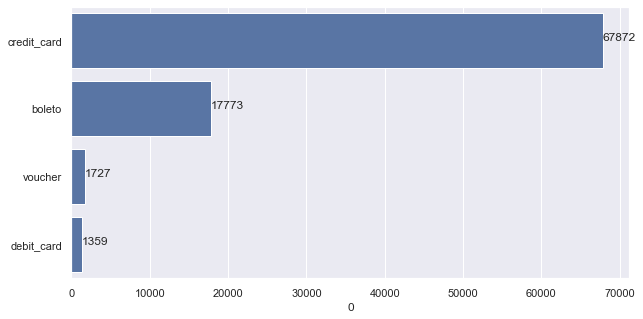

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=payment_type_count[0],
           y=payment_type_count.index,
           color='b',
           orient='h')
show_values_on_bars(ax, vertical=False);

**customer_state**

In [76]:
customer_state_count = pd.DataFrame.from_dict(dict(customer_data['customer_state'].value_counts())
                                    ,orient='index')

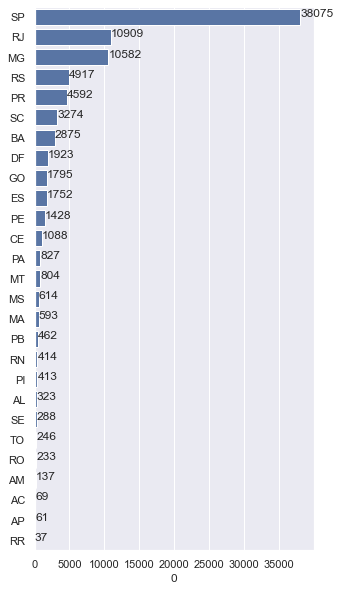

In [84]:
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x=customer_state_count[0],
           y=customer_state_count.index,
           color='b',
           orient='h')
show_values_on_bars(ax, vertical=False);

**product_category_name**

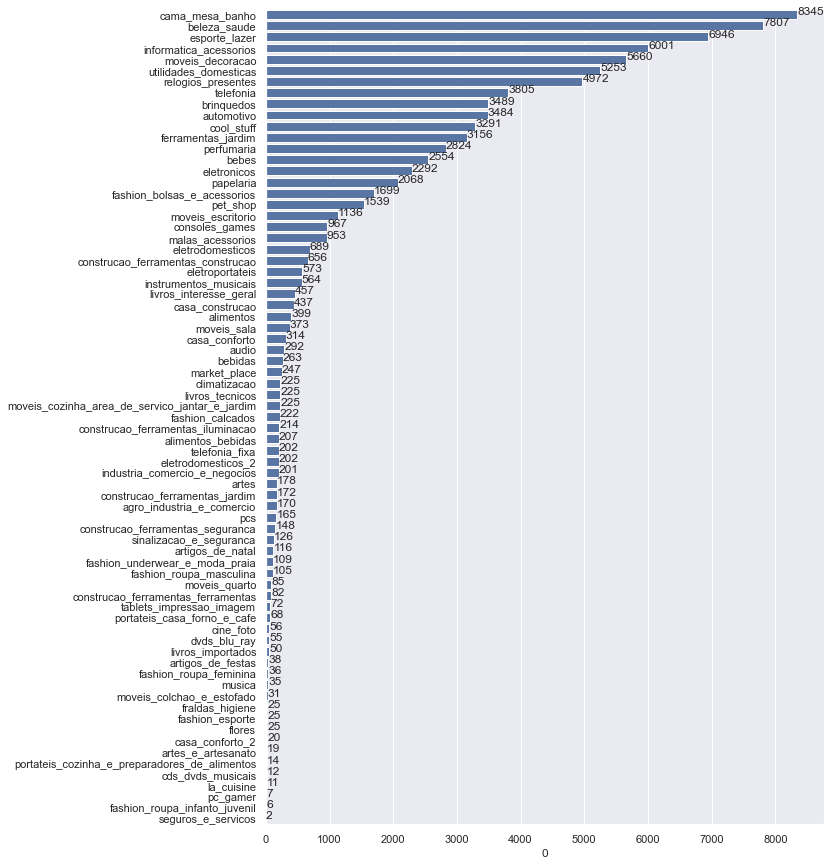

In [86]:
product_category_name_count = pd.DataFrame.from_dict(dict(customer_data['product_category_name'].value_counts())
                                    ,orient='index')

fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(x=product_category_name_count[0],
           y=product_category_name_count.index,
           color='b',
           orient='h')
show_values_on_bars(ax, vertical=False);

In [67]:
year_count = pd.DataFrame.from_dict(dict(customer_data['year'].value_counts())
                                    ,orient='index')

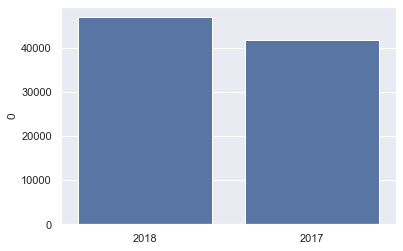

In [72]:
sns.barplot(x=year_count.index,
           y=year_count[0],
           color='b',
           orient='v');

### 4.2 Variables Quantitatives

In [88]:
customer_data[["payment_sequential",
               "payment_installments",
               "average_basket",
               "product_weight_g",
               "product_volume_cm3",
               "freight_value",
               "R_score",
               "F_score",
               "M_score"]].describe()

,payment_sequential,payment_installments,average_basket,product_weight_g,product_volume_cm3,freight_value,R_score,F_score,M_score
count,88731.000000,88731.000000,88731.000000,88731.000000,88731.000000,88731.000000,88731.000000,88731.000000,88731.000000
mean,1.022512,1.275690,207.152064,2086.596688,15147.004733,19.968777,3.932369,0.995616,43.838151
std,0.193966,1.282147,646.477767,3725.517555,23257.386555,15.587414,2.793036,0.066067,72.720169
min,1.000000,0.000000,9.590000,2.000000,168.000000,0.000000,1.000000,0.000000,2.000000
25%,1.000000,1.000000,62.500000,300.000000,2816.000000,13.160000,1.000000,1.000000,15.000000
50%,1.000000,1.000000,109.390000,700.000000,6400.000000,16.230000,3.000000,1.000000,26.000000
75%,1.000000,1.000000,195.910000,1800.000000,18150.000000,21.020000,6.000000,1.000000,47.000000
max,15.000000,24.000000,109312.640000,40425.000000,296208.000000,409.680000,10.000000,1.000000,1000.000000


In [93]:
customer_data['nb_orders'].max()

1

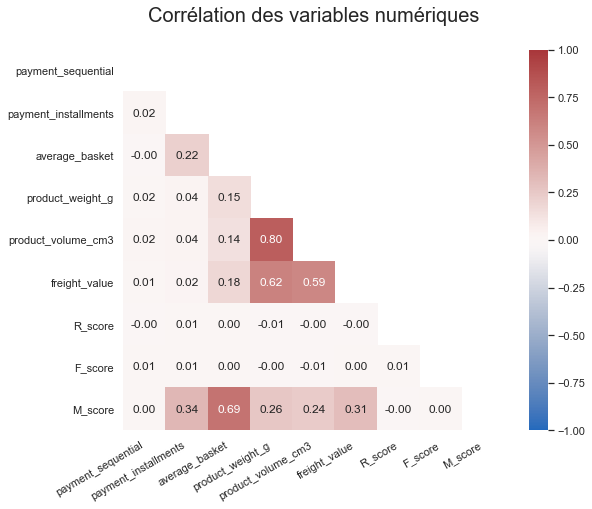

In [95]:
corr = customer_data[["payment_sequential",
               "payment_installments",
               "average_basket",
               "product_weight_g",
               "product_volume_cm3",
               "freight_value",
               "R_score",
               "F_score",
               "M_score"]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, cmap='vlag', vmin=-1, annot=True, fmt='.2f')
    ax.set_xticklabels(labels=customer_data[["payment_sequential",
               "payment_installments",
               "average_basket",
               "product_weight_g",
               "product_volume_cm3",
               "freight_value",
               "R_score",
               "F_score",
               "M_score"]].columns, rotation=30, horizontalalignment='right')
    plt.title("Corrélation des variables numériques\n", fontsize=20)

### 4.3 Analyse métier

#### 4.3.1 Évolution du nombre de clients

In [96]:
year_count

,0
2018,46913
2017,41818


In [107]:
print(f"Augmentation entre 2017 et 2018 : {(1 - (year_count[0][1] / year_count[0][0])) * 100:.2f} %")

Augmentation entre 2017 et 2018 : 10.86 %


#### 4.3.2 Évolution du nombre de clients par état

In [109]:

customer_data_years = {2017:customer_data_2017,
                       2018:customer_data_2018}

data_clients_state = pd.DataFrame(columns=["customer_state",
                                           "% of clients",
                                           "year"])

for year, data in customer_data_years.items():
    for customer_state, data_df in data.groupby("customer_state"):
        row = [customer_state,
               data_df["customer_id"].nunique()*100/data["customer_id"].nunique(),
               year]

        data_clients_state.loc[len(data_clients_state)] = row

In [110]:
sorted_data_clients_state = data_clients_state[data_clients_state["year"] == 2017]\
                            .rename(columns={"% of clients":"% of clients - 2017"})\
                            .drop(columns="year")\
                            .join(data_clients_state[data_clients_state["year"] == 2018]\
                                  .rename(columns={"% of clients":"% of clients - 2018"})\
                                  .drop(columns="year").set_index("customer_state"), on="customer_state")\
                            .sort_values(by=["% of clients - 2018",
                                             "% of clients - 2017"],
                                         ascending=False)

In [111]:
sorted_data_clients_state

,customer_state,% of clients - 2017,% of clients - 2018
25,SP,40.099957,45.415983
10,MG,12.310488,11.583143
18,RJ,13.245492,11.446721
17,PR,5.124587,5.220301
22,RS,5.937635,5.188327
23,SC,3.806973,3.585360
4,BA,3.357406,3.135591
6,DF,2.049357,2.272291
8,GO,2.133053,1.924840
7,ES,2.121096,1.843839


#### 4.3.2 Évolution du CA par état

In [112]:
CA_total_2017 = customer_data_2017["average_basket"].sum()
CA_state_2017 = customer_data_2017.groupby("customer_state").agg("sum")
CA_state_2017["% of CA - 2017"] = CA_state_2017["average_basket"]\
                                  .apply(lambda x: x*100/CA_total_2017)
CA_state_2017 = CA_state_2017[["% of CA - 2017"]]

CA_total_2018 = customer_data_2018["average_basket"].sum()
CA_state_2018 = customer_data_2018.groupby("customer_state").agg("sum")
CA_state_2018["% of CA - 2018"] = CA_state_2018["average_basket"]\
                                  .apply(lambda x: x*100/CA_total_2018)
CA_state_2018 = CA_state_2018[["% of CA - 2018"]]

CA_state_year = CA_state_2017.join(CA_state_2018)\
                .sort_values(by=["% of CA - 2018",
                                 "% of CA - 2017"],
                             ascending=False)

CA_state_year

,% of CA - 2017,% of CA - 2018
customer_state,,
SP,35.538386,40.742912
RJ,14.483177,11.831752
MG,12.105372,11.312470
RS,5.997598,5.449824
PR,5.269590,5.428822
SC,3.743632,4.069017
BA,3.785422,3.758339
GO,2.862985,2.367680
DF,2.200560,2.156359


In [122]:
full_dataset['customer_unique_id'].nunique()

86122

In [123]:
full_dataset['customer_id'].nunique()

88731

In [125]:
full_dataset.shape

(106620, 39)

In [127]:
full_dataset['order_id'].nunique()

88731

In [133]:
full_dataset[full_dataset.duplicated('order_id', keep=False)].sort_values('order_id')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
53957,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-20 18:23:28,2018-02-26 13:55:22,2018-03-06,5505c1cce299b1e0b3f8e4b428417362,5,...,30.0,22.0,30.0,15025.0,sao jose do rio preto,SP,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
53957,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-20 18:23:28,2018-02-26 13:55:22,2018-03-06,5505c1cce299b1e0b3f8e4b428417362,5,...,30.0,22.0,30.0,15025.0,sao jose do rio preto,SP,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,29ae131f1e1b52d81fb3ff6427ceb007,1,...,17.0,11.0,14.0,18055.0,sorocaba,SP,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,29ae131f1e1b52d81fb3ff6427ceb007,1,...,17.0,11.0,14.0,18055.0,sorocaba,SP,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,29ae131f1e1b52d81fb3ff6427ceb007,1,...,17.0,11.0,14.0,18055.0,sorocaba,SP,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85166,fff8287bbae429a99bb7e8c21d151c41,6c1e92a209dbf868706caa831090941e,delivered,2018-03-17 12:11:45,2018-03-17 12:29:22,2018-03-21 19:22:25,2018-04-07 10:07:48,2018-04-19,2b97d83f7c2b3a3b4285174e77379fbc,5,...,20.0,20.0,20.0,12327.0,jacarei,SP,028c09f007292c4e3a3b10d296e47987,58075,joao pessoa,PB
61990,fffb9224b6fc7c43ebb0904318b10b5f,4d3abb73ceb86353aeadbe698aa9d5cb,delivered,2017-10-27 16:51:00,2017-10-28 02:55:58,2017-11-10 19:31:52,2017-11-17 19:41:42,2017-11-27,269edb5280ad1f999b5043c93cc4e845,4,...,16.0,14.0,11.0,24440.0,sao goncalo,RJ,f736308cd9952b33b90b9fe94da9c8f5,56912,serra talhada,PE
61990,fffb9224b6fc7c43ebb0904318b10b5f,4d3abb73ceb86353aeadbe698aa9d5cb,delivered,2017-10-27 16:51:00,2017-10-28 02:55:58,2017-11-10 19:31:52,2017-11-17 19:41:42,2017-11-27,269edb5280ad1f999b5043c93cc4e845,4,...,16.0,14.0,11.0,24440.0,sao goncalo,RJ,f736308cd9952b33b90b9fe94da9c8f5,56912,serra talhada,PE
61990,fffb9224b6fc7c43ebb0904318b10b5f,4d3abb73ceb86353aeadbe698aa9d5cb,delivered,2017-10-27 16:51:00,2017-10-28 02:55:58,2017-11-10 19:31:52,2017-11-17 19:41:42,2017-11-27,269edb5280ad1f999b5043c93cc4e845,4,...,16.0,14.0,11.0,24440.0,sao goncalo,RJ,f736308cd9952b33b90b9fe94da9c8f5,56912,serra talhada,PE


In [1]:
def display_cate_bar(data, var, show_values=True, figsize=(5,5), color='b'):
    value_cont = pd.DataFrame.from_dict(dict(data[var].value_counts())
                                    ,orient='index')
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=value_cont[0],
       y=value_cont.index,
       color=color,
       orient='h')
    if show_values:
        show_values_on_bars(ax, vertical=False)